# SIRD model playground

Given the following equations of the SIRD model

\begin{align*}
\frac{dS}{dt} &= -\beta \cdot S \cdot I \\
\frac{dI}{dt} &= \beta \cdot S \cdot I - (\gamma \cdot I) - (\delta \cdot I) \\
\frac{dR}{dt} &= \gamma \cdot I \\
\frac{dD}{dt} &= \delta \cdot I
\end{align*}

Given the initial conditions: *population, cases, deaths, recovered* and *Basic reproductive rate (R0), Mortality rate ratio (M), Average infectios period (P)* it is possible to compute the correspondent ODEs and then obtain the *S, I, R, D* params

In [7]:
from sird_base_model import SIRD
import matplotlib.pyplot as plt
import pandas as pd
from pso import Config, MySIRD

DAYS = Config.DAYS
LAG = Config.LAG
print(F"USING LAG: {LAG}, DAYS: {DAYS}")
parent_class = MySIRD()

USING LAG: 7, DAYS: 21


In [8]:
def get_params_from_file():
    FOLDER = "../data/solutions/baseline.csv"
    with open(FOLDER) as f:
        res = pd.read_csv(f) 
    return res.iloc[0].to_dict()

In [9]:
beta = 0.6397873716594259
gamma = 0.02598574446744427
delta = 0.2757542890507501

beta, gamma, delta = get_params_from_file().values()
print(beta, gamma, delta)
#beta, gamma, delta = 0.639, 0.2757, 0.0259#0.35, 0.001, 0.442

0.8192905620669977 0.001 0.001


In [10]:
model = SIRD(beta=beta, gamma=gamma, delta=delta)
initial_conditions, _ = parent_class.get_sird_from_data(start_week=LAG, end_week=LAG+DAYS, population=parent_class.population)
initial_conditions

{'population': 60000000,
 'initial_I': 1577.0,
 'initial_R': 83.0,
 'initial_D': 34.0,
 'initial_S': 59998306.0}

For a population of 60000000 people, after 28 days there were:
0.8% total deaths, or 0 people.
0.8% total recovered, or 0 people.
At the virus' maximum 98.3% people were simultaneously infected, or 1 people.
After 28 days the virus was present in less than 1 individuals.


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.122e-01 ...  2.049e+01  2.100e+01]
        y: [[ 1.000e+00  1.000e+00 ...  2.143e-03  1.422e-03]
            [ 2.628e-05  3.999e-05 ...  9.829e-01  9.826e-01]
            [ 1.383e-06  1.400e-06 ...  7.500e-03  8.004e-03]
            [ 5.667e-07  5.834e-07 ...  7.499e-03  8.003e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 80
     njev: 0
      nlu: 0

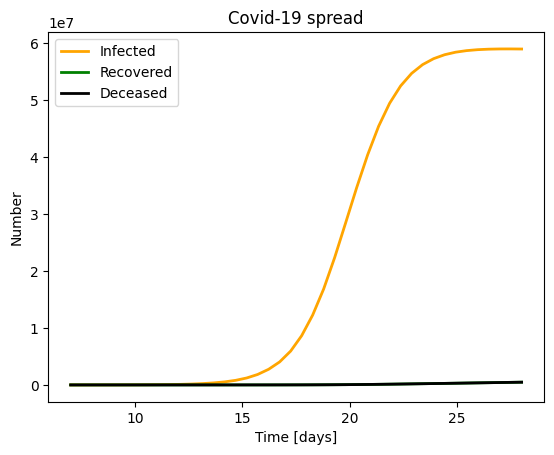

In [11]:
days = DAYS
model.solve(initial_conditions, days)
model.plot(susceptible=False, lag = LAG)
model.soln

In [12]:
# Parameters after a simulation
params = model.get_sird_values()
print(params)

{'S': 85317.65400863226, 'I': 58954291.29244365, 'R': 480220.02677386027, 'D': 480171.0267738603, 'Sum params:': 60000000.0}


,totale_positivi,dimessi_guariti,deceduti
7,1835,149,52
8,2263,160,79
9,2706,276,107
10,3296,414,148
11,3916,523,197
12,5061,589,233
13,6387,622,366
14,7985,724,463
15,8514,1004,631
16,10590,1045,827


<Axes: >

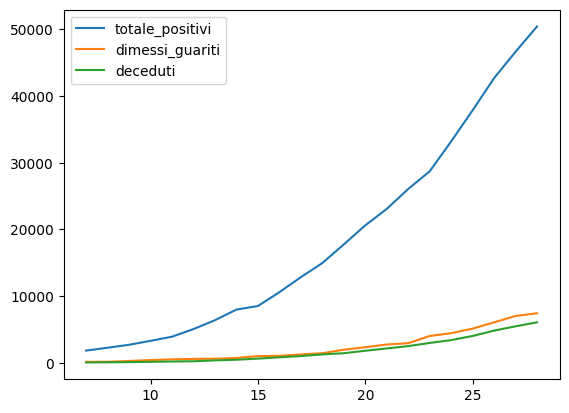

In [13]:
# Viz real data
df = pd.read_csv('../data/daily_processed.csv')
# Lineplot totale_positivi, dimessi_guariti, deceduti giving iloc
partial_df = df.iloc[LAG:LAG+DAYS+1, 1:4]
display(partial_df)
partial_df.plot()

For a population of 60000000 people, after 28 days there were:
0.8% total deaths, or 0 people.
0.8% total recovered, or 0 people.
At the virus' maximum 98.3% people were simultaneously infected, or 1 people.
After 28 days the virus was present in less than 1 individuals.


<Axes: title={'center': 'Covid-19 spread'}, xlabel='Time [days]', ylabel='Number'>

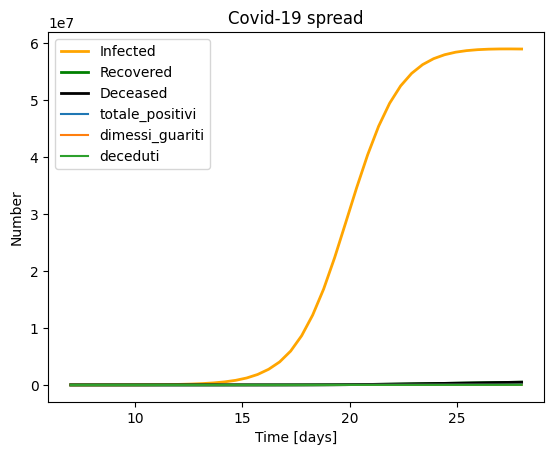

In [14]:
s, i, r, d = model.get_sird_series().values()
# from this list plot the series converted to pandas
computed_df = pd.DataFrame({
    'I': i,
    'R': r,
    'D': d
})

partial_df.plot(ax=model.plot(susceptible=False, lag=LAG))